In [78]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import os

In [79]:
#Variables
#orange_signs_list = os.listdir('./Img/RawOrangeSignImgs/')
#coco_imgs_list = os.listdir('./coco_dataset/images/chosenImages')
orange_signs_list = ['R-2_000.png']
#orange_signs_list = ['SAE_000.png']
# coco_imgs_list = ['000000000025.jpg']



In [80]:
def createMasks(orange_signs_list):
    mask_dict = {}
    for name in orange_signs_list:
        name = name[:-4:] # remove .png
        sign_type = name[:-4:] # select the sign type
        sign_number = name[-4::] # select the number of this sign type
        img = cv2.imread(f'./Img/RawOrangeSignImgs/{sign_type + sign_number}.png')
        #print('Img Shape:', img.shape)

        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
        #print("HSV Img Shape: ", hsv_img.shape)

        lower_limit = np.array([12, 255, 255]) #Background HSV Color
        upper_limit = np.array([12, 255, 255]) #Background HSV Color

        mask = cv2.inRange(hsv_img, lower_limit, upper_limit)
        mask_inv = cv2.bitwise_not(mask)

        if not mask_dict.get(sign_type):
            mask_dict[sign_type] = [(sign_number, mask_inv)]
        else:
            mask_dict[sign_type].append((sign_number, mask_inv))

    return mask_dict
        
masks_dict = createMasks(orange_signs_list)
print(masks_dict)

{'R-2': [('_000', array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8))]}


Text(0.5, 0.98, 'BGR Channels')

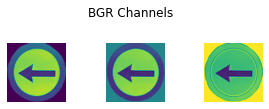

In [81]:
img = cv2.imread('./Img/RawOrangeSignImgs/R-24a_001.png')
#print('Img Shape:', img.shape) #(287, 124, 3)

fig = plt.figure(figsize=(5, 5))
#Blue Channel
fig.add_subplot(4, 3, 1)
plt.imshow(img[:,:,0])
plt.axis('off')
#GreenChannel
fig.add_subplot(4, 3, 2)
plt.imshow(img[:,:,1])
plt.axis('off')
#Red Channel
fig.add_subplot(4, 3, 3)
plt.imshow(img[:,:,2])
plt.axis('off')

fig.suptitle("BGR Channels")

In [82]:
def pixelColorPrint(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN: #checks mouse left button down condition
        colorsB = img[y,x,0]
        colorsG = img[y,x,1]
        colorsR = img[y,x,2]
        colors = img[y,x]
        hsv_value= np.uint8([[[ colorsB,colorsG,colorsR ]]])
        print(hsv_value)
        hsv = cv2.cvtColor(hsv_value,cv2.COLOR_BGR2HSV)
        print ("HSV : " ,hsv)
        print("Coordinates of pixel: X: ",x,"Y: ",y)

# cv2.namedWindow('GetPixelColor')
# cv2.setMouseCallback('GetPixelColor', pixelColorPrint)

# while(1):
#     cv2.imshow('GetPixelColor', img)
#     hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     #cv2.imshow('GetPixelColor', hsv_img)

#     if cv2.waitKey(0):
#         break
    
# cv2.destroyAllWindows()

In [83]:
def dilate(img):
  kernel = np.ones((5,5), np.uint8)
  img_dilated = cv2.dilate(img, kernel, iterations=1)  # Número de iterações controla o quanto dilata
  return img_dilated

def erode(mask):
  kernel = np.ones((5,5), np.uint8)
  mask = cv2.erode(mask, kernel, iterations=1)
  return mask

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# print(hsv_img)
# cv2.imshow('Sign', hsv_img)
# cv2.waitKey(0)
#print("HSV Img Shape: ", hsv_img.shape) #(287, 124, 3)

lower_limit = np.array([12, 255, 255]) #Background HSV Color
upper_limit = np.array([12, 255, 255]) #Background HSV Color

mask = cv2.inRange(hsv_img, lower_limit, upper_limit)
mask_inv = cv2.bitwise_not(mask)

# fig = plt.figure(figsize=(10, 10))
# #Orange Mask
# fig.add_subplot(4, 3, 1)
# plt.imshow(mask)
# plt.axis('off')
# plt.title('Orange Mask')
# #Content mask
# fig.add_subplot(4, 3, 2)
# plt.imshow(mask_inv)
# plt.axis('off')
# plt.title('Sign Mask')
# Content mask
#mask_inv = erode(mask_inv) # Torna a mascara um pouco maior para facilitar a detecção.
# fig.add_subplot(4, 3, 3)
# plt.imshow(mask_inv)
# plt.axis('off')
# plt.title('Sign Mask Dilated')

# fig.suptitle("Masks")

# cv2.imshow('Mask Inv', mask_inv)
# cv2.waitKey(0)



-1

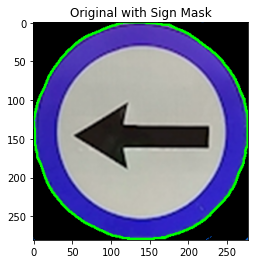

In [84]:

contours, hierarchy = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(np.asarray(contours).shape) # (1, 86, 1, 2) - 1 array, com 86 listas, cada lista com 1 sublistas com 2 elementos.
valid_contours = []

#Retira ruídos e monta pega o contorno principal
for c in contours:
    area = cv2.contourArea(c)
    if area < 600:
        continue
    
    valid_contours.append(c)   #Optamos por reduzir pela metade o número de pontos do contorno, pode ser revertido     

#Une a máscara invertida sobre a imagem principal para destacar a placa 
img_sign = cv2.bitwise_and(img, img, mask= mask_inv)
#print(img_sign.shape) #(287, 124, 3)

#Desenha os contornos na img_sign
cv2.drawContours(img_sign, valid_contours, -1, (0,255,0), 2)
plt.imshow(img_sign)
plt.title("Original with Sign Mask")

cv2.imshow('Sign', img_sign)
cv2.waitKey(0)

In [85]:
dict = {}
dict['teste'] = ('abc', 'def')
print(dict)


{'teste': ('abc', 'def')}


In [86]:
#Check size of default training data
img_test = cv2.imread('./Img/TrainingSet/0gn0Cmm6E9F85hlXenNJGQ.jpg', cv2.IMREAD_UNCHANGED)
resized = cv2.resize(img_test, (1366, 768), interpolation=cv2.INTER_AREA)
print(img_test.shape)
print(resized.shape)
cv2.imshow('Test', resized)
cv2.waitKey(0)

#(1152, 2048, 3) #(H, W, RGB)
# dim (2048, 1152) #(W, H)

(1152, 2048, 3)
(768, 1366, 3)


-1

In [87]:
teste = {"type1": [("number1", "data1"), ("number2", "data2")], 
        "type2": [("number3", "data3"), ("number4", "data4")]}

for types in teste:
    for i, data in enumerate(teste[types]):
        print(i, data)

0 ('number1', 'data1')
1 ('number2', 'data2')
0 ('number3', 'data3')
1 ('number4', 'data4')
